In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [15]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder

## params

In [5]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
transformer_path = data_folder + 'best_model_20240318_lib_cos_sim.ckpt'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'

In [6]:
config=Config()

## open janssen data

In [7]:
loader_saver = LoaderSaver(
        block_size=100,
        pickle_nist_path='',
        pickle_gnps_path='',
        pickle_janssen_path=output_janssen_file,
    )

In [8]:
all_spectrums_janssen = loader_saver.get_all_spectrums(
            janssen_path,
            100000000,
            use_tqdm=True,
            use_nist=False,
            config=config,
            use_janssen=True,
        )

python(79255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  0%|                                                                                                                                                                 | 2033/100000000 [00:01<20:38:44, 1345.42it/s]


We reached the end of the array at index 2033


## open training data

In [9]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)
molecule_pairs_train= dataset['molecule_pairs_train']
molecule_pairs_val= dataset['molecule_pairs_val']
molecule_pairs_test= dataset['molecule_pairs_test']

In [10]:
molecule_pairs_train

##  Select one spectra from the Janssen as target

In [11]:
target_spectra= all_spectrums_janssen[0]

In [13]:
target_spectra.params

{'pepmass': (380.2683, None),
 'rt': '5.51',
 'ionmode': 'Positive',
 'adduct': 'M+',
 'charge': [1],
 'id': 'DNYBIOICMDTDAP',
 'smiles': 'CC(C)c1cnn2c(cc(NCCCCCCN)nc12)NCc1ccccc1',
 'formula': 'C22H32N6',
 'filename': '2600129002_190419_MAS011_A1.mzXML',
 'drugbank.id': 'Unknown',
 'inchikey': 'DNYBIOICMDTDAP-UHFFFAOYSA-N',
 'cpd': 'BS-181',
 'status': 'experimental',
 'cas': 'N/A',
 'name': 'BS-181',
 'mslevel': '2',
 'tic': '71384813.4375',
 'pepmass_dev': '0.00101425948357327',
 'scan_number': '517',
 'param_submit_user': '',
 'param_sample_type': '',
 'param_comments': '',
 'param_algorithm': 'RMassBank',
 'param_creation_time': '2021-06-26 21:49:30',
 'scans': '3',
 'db': 'Inhouse',
 'class': 'Pyrazolopyrimidines',
 'num_peaks': '52',
 'param_consensus': 'consensus',
 'superclass': 'Organoheterocyclic compounds',
 'subclass': 'Pyrazolo[1,5-a]pyrimidines'}

## Create pairs with this spectra

In [75]:
spectrums_base= molecule_pairs_train.spectrums_original + molecule_pairs_val.spectrums_original + molecule_pairs_test.spectrums_original

NameError: name 'molecule_pairs_val' is not defined

In [14]:
total_spectra= [all_spectrums_janssen[0]] +spectrums_base

In [29]:
import pandas as pd
df_smiles = pd.DataFrame()
df_smiles['indexes']= [[ind] for ind in np.arange(0,len(spectrums_base)+1)]

In [30]:
indexes_tani=np.zeros((len(spectrums_base),3))

In [31]:
indexes_tani[:,1] =  np.arange(0,len(spectrums_base))

In [32]:
discovery_pairs = MoleculePairsOpt(
                        spectrums_unique = total_spectra,
                        spectrums_original = total_spectra,
                        indexes_tani_unique=indexes_tani,
                        df_smiles=df_smiles,
)

In [34]:
model =SklearnModel(model_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


In [35]:
scores_trans=model.predict_from_molecule_pair(discovery_pairs)

Preprocessing all the data ...


261350it [00:05, 50877.76it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261349/261349 [00:02<00:00, 102966.28it/s]


Preprocessing all the data ...


261350it [00:03, 72410.69it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


In [36]:
scores_trans

array([0.99999982, 0.3843779 , 0.26581323, ..., 0.24664937, 0.24323639,
       0.29153156])

## Assign predictions

In [38]:
discovery_pairs.pred = scores_trans

## Which are the spectra that are closer to this compound?

(array([4.1097e+04, 8.8217e+04, 8.3873e+04, 3.3161e+04, 9.3920e+03,
        3.5670e+03, 1.5060e+03, 3.9600e+02, 1.3200e+02, 8.0000e+00]),
 array([0.01155352, 0.11039815, 0.20924278, 0.30808741, 0.40693204,
        0.50577667, 0.6046213 , 0.70346593, 0.80231056, 0.90115519,
        0.99999982]),
 <BarContainer object of 10 artists>)

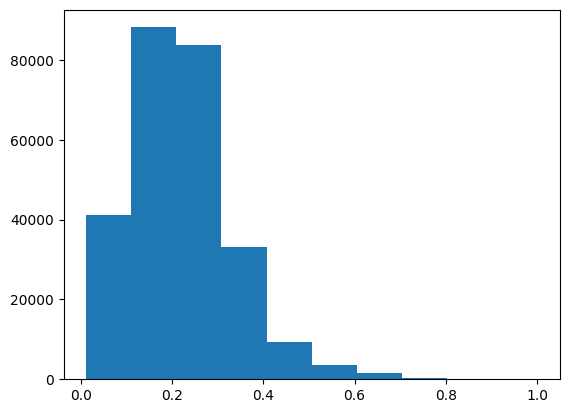

In [40]:
import matplotlib.pyplot as plt
plt.hist(scores_trans)

In [66]:
possible_spectra= [m for m,s in zip(discovery_pairs, scores_trans) if s>0.90]

In [67]:
len(possible_spectra)

8

In [68]:
target_smiles= 'CC(C)c1cnn2c(cc(NCCCCCCN)nc12)NCc1ccccc1'

In [69]:
possible_spectra[1].params_1

{'libraryquality': 1,
 'charge': [1],
 'pepmass': [381.2761],
 'ionmode': 'Positive',
 'name': ' 6-Aminohexyl-[7-(benzylamino)-3-isopropylpyrazolo[1,5-a]pyrimidin-5-yl]amine\n M+H',
 'inchi': 'N/A',
 'smiles': 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'organism': 'nist',
 'spectrumid': 'abcd'}

In [70]:
[s.smiles_1 for s in possible_spectra]

['CC(C)c1cnn2c(cc(NCCCCCCN)nc12)NCc1ccccc1',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN']

## Check results

In [71]:
from src.tanimoto import Tanimoto


In [1]:
Tanimoto.compute_tanimoto_from_smiles('CC(C)c1cnn2c(cc(NCCCCCCN)nc12)NCc1ccccc1','CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN')

NameError: name 'Tanimoto' is not defined